# Welcome to Kijang Emas analysis!

![alt text](http://www.bnm.gov.my/images/kijang_emas/kijang.rm200.jpg)

I was found around last week (18th March 2019), our Bank Negara opened public APIs for certain data, it was really cool and I want to help people get around with the data and what actually they can do with the data!

We are going to cover 2 things here,

1. Data Analytics
2. Predictive Modelling (Linear regression, ARIMA, LSTM)

Hell, I know nothing about Kijang Emas.

**Again, do not use this code to buy something on the real world (if got positive return, please donate some to me)**

In [1]:
import requests

## Data gathering

To get the data is really simple, use this link to get kijang emas data, https://api.bnm.gov.my/public/kijang-emas/year/{year}/month/{month}

Now, I want to get data from january 2018 - march 2019.

#### 2018 data

In [29]:
requests.get(
        'https://api.bnm.gov.my/public/kijang-emas/date/2018-11-05',
        headers = {'Accept': 'application/vnd.BNM.API.v1+json'},
    ).json()

{'message': 'No records found.', 'code': 404}

In [2]:
data_2018 = []
for i in range(12):
    data_2018.append(requests.get(
        'https://api.bnm.gov.my/public/kijang-emas/year/2018/month/%d'%(i + 1),
        headers = {'Accept': 'application/vnd.BNM.API.v1+json'},
    ).json())

#### 2019 data

In [3]:
data_2019 = []
for i in range(3):
    data_2019.append(requests.get(
        'https://api.bnm.gov.my/public/kijang-emas/year/2019/month/%d'%(i + 1),
        headers = {'Accept': 'application/vnd.BNM.API.v1+json'},
    ).json())

#### Take a peak our data ya

In [4]:
data_2018[0]['data'][:5]

[]

Again, I got zero knowledge on kijang emas and I don't really care about the value, and I don't know what the value represented.

Now I want to parse `effective_date` and `buying` from `one_oz`.

In [5]:
timestamp, selling = [], []
for month in data_2018 + data_2019:
    for day in month['data']:
        timestamp.append(day['effective_date'])
        selling.append(day['one_oz']['selling'])
        
len(timestamp), len(selling)

(0, 0)

Going to import matplotlib and seaborn for visualization, I really seaborn because of the font and colors, thats all, hah!

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

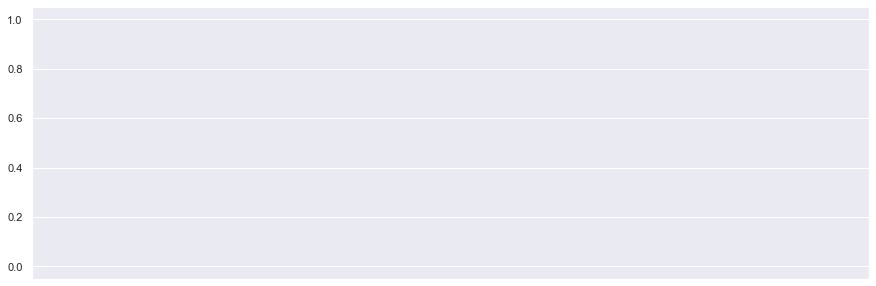

In [7]:
plt.figure(figsize = (15, 5))
plt.plot(selling)
plt.xticks(np.arange(len(timestamp))[::15], timestamp[::15], rotation = '45')
plt.show()

## Perfect!

So now let's we start our Data analytics.

#### Distribution study

/Users/bochmann/lib/anaconda3/envs/gcstf/lib/python3.7/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/Users/bochmann/lib/anaconda3/envs/gcstf/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/bochmann/lib/anaconda3/envs/gcstf/lib/python3.7/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


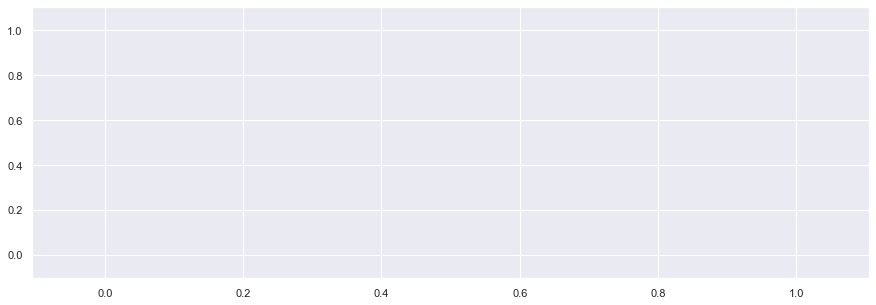

In [8]:
plt.figure(figsize = (15, 5))
sns.distplot(selling)
plt.show()

Look at this, already normal distribution, coincidence? (I really wanted to show off unit scaling skills, too bad :/ )

Now let's change our into Pandas, for lagging analysis.

In [9]:
import pandas as pd
df = pd.DataFrame({'timestamp':timestamp, 'selling':selling})
df.head()

,timestamp,selling


In [10]:
def df_shift(df, lag = 0, start = 1, skip = 1, rejected_columns = []):
    df = df.copy()
    if not lag:
        return df
    cols = {}
    for i in range(start, lag + 1, skip):
        for x in list(df.columns):
            if x not in rejected_columns:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k, v in cols.items():
        columns = v
        dfn = pd.DataFrame(data = None, columns = columns, index = df.index)
        i = start - 1
        for c in columns:
            dfn[c] = df[k].shift(periods = i)
            i += skip
        df = pd.concat([df, dfn], axis = 1, join_axes = [df.index])
    return df

**Shifted and moving average are not same.**

In [11]:
df_crosscorrelated = df_shift(
    df, lag = 12, start = 4, skip = 2, rejected_columns = ['timestamp']
)
df_crosscorrelated['ma7'] = df_crosscorrelated['selling'].rolling(7).mean()
df_crosscorrelated['ma14'] = df_crosscorrelated['selling'].rolling(14).mean()
df_crosscorrelated['ma21'] = df_crosscorrelated['selling'].rolling(21).mean()

/Users/bochmann/lib/anaconda3/envs/gcstf/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.


## why we lagged or shifted to certain units?

Virals took some time, impacts took some time, same goes to price lot / unit.

Now I want to `lag` for until 12 units, `start` at 4 units shifted, `skip` every 2 units.

In [12]:
df_crosscorrelated.head(21)

,timestamp,selling,selling_4,selling_6,selling_8,selling_10,selling_12,ma7,ma14,ma21


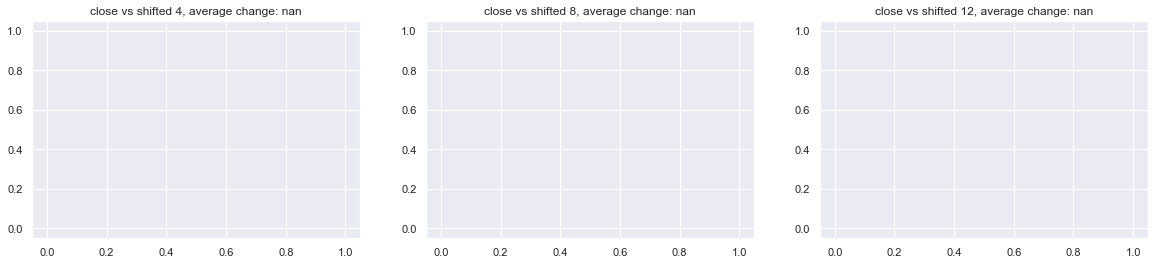

In [13]:
plt.figure(figsize = (20, 4))
plt.subplot(1, 3, 1)
plt.scatter(df_crosscorrelated['selling'], df_crosscorrelated['selling_4'])
mse = (
    (df_crosscorrelated['selling_4'] - df_crosscorrelated['selling']) ** 2
).mean()
plt.title('close vs shifted 4, average change: %f'%(mse))
plt.subplot(1, 3, 2)
plt.scatter(df_crosscorrelated['selling'], df_crosscorrelated['selling_8'])
mse = (
    (df_crosscorrelated['selling_8'] - df_crosscorrelated['selling']) ** 2
).mean()
plt.title('close vs shifted 8, average change: %f'%(mse))
plt.subplot(1, 3, 3)
plt.scatter(df_crosscorrelated['selling'], df_crosscorrelated['selling_12'])
mse = (
    (df_crosscorrelated['selling_12'] - df_crosscorrelated['selling']) ** 2
).mean()
plt.title('close vs shifted 12, average change: %f'%(mse))
plt.show()

Keep increasing and increasing!

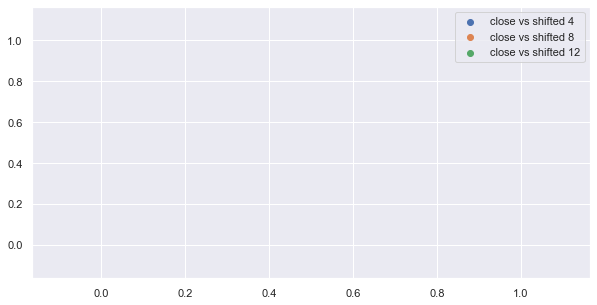

In [14]:
plt.figure(figsize = (10, 5))
plt.scatter(
    df_crosscorrelated['selling'],
    df_crosscorrelated['selling_4'],
    label = 'close vs shifted 4',
)
plt.scatter(
    df_crosscorrelated['selling'],
    df_crosscorrelated['selling_8'],
    label = 'close vs shifted 8',
)
plt.scatter(
    df_crosscorrelated['selling'],
    df_crosscorrelated['selling_12'],
    label = 'close vs shifted 12',
)
plt.legend()
plt.show()

TypeError: no numeric data to plot

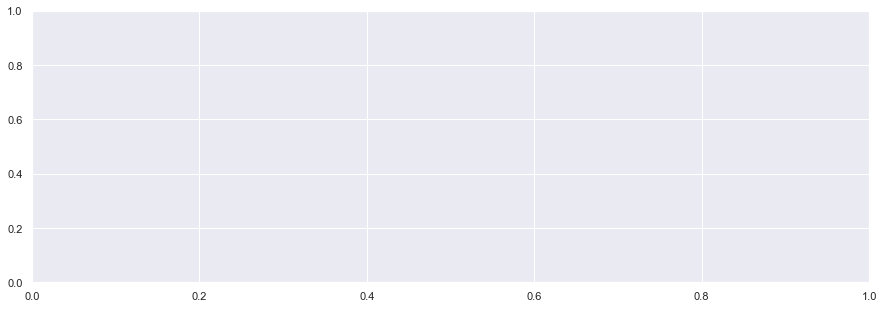

In [15]:
fig, ax = plt.subplots(figsize = (15, 5))
df_crosscorrelated.plot(
    x = 'timestamp', y = ['selling', 'ma7', 'ma14', 'ma21'], ax = ax
)
plt.xticks(np.arange(len(timestamp))[::10], timestamp[::10], rotation = '45')
plt.show()

As you can see, even moving average 7 already not followed sudden trending (blue line), means that, **dilation rate required less than 7 days! so fast!**

#### How about correlation?

We want to study linear relationship between, how many days required to give impact to future sold units?

In [ ]:
colormap = plt.cm.RdBu
plt.figure(figsize = (15, 5))
plt.title('cross correlation', y = 1.05, size = 16)

sns.heatmap(
    df_crosscorrelated.iloc[:, 1:].corr(),
    linewidths = 0.1,
    vmax = 1.0,
    cmap = colormap,
    linecolor = 'white',
    annot = True,
)
plt.show()

Based on this correlation map, look at selling vs selling_X,

**selling_X from 4 to 12 is getting lower, means that, if today is 50 mean, next 4 days should increased by 0.95 * 50 mean, and continue.**

#### Outliers

Simple, we can use Z-score to detect outliers, which timestamps gave very uncertain high and low value.

In [ ]:
std_selling = (selling - np.mean(selling)) / np.std(selling)

In [ ]:
def detect(signal, treshold = 2.0):
    detected = []
    for i in range(len(signal)):
        if np.abs(signal[i]) > treshold:
            detected.append(i)
    return detected

Based on z-score table, 2.0 already positioned at 97.772% of the population.

https://d2jmvrsizmvf4x.cloudfront.net/6iEAaVSaT3aGP52HMzo3_z-score-02.png

In [ ]:
outliers = detect(std_selling)

In [ ]:
plt.figure(figsize = (15, 7))
plt.plot(selling)
plt.plot(
    np.arange(len(selling)),
    selling,
    'X',
    label = 'outliers',
    markevery = outliers,
    c = 'r',
)
plt.legend()
plt.show()

We can see that, **we have positive and negative outliers**. What happened to our local market on that days? So we should study sentiment from local news to do risk analysis.

# Give us predictive modelling!

Okay okay.

## Predictive modelling

Like I said, I want to compare with 3 models,

1. Linear regression
2. ARIMA
3. LSTM Tensorflow (sorry Pytorch, not used to it)

Which models give the best accuracy and lowest error rate?

**I want to split first timestamp 80% for train, another 20% timestamp for test.**

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
train_selling = selling[: int(0.8 * len(selling))]
test_selling = selling[int(0.8 * len(selling)) :]

Beware of `:`!

In [ ]:
future_count = len(test_selling)
future_count

Our model should forecast 61 future days ahead.

#### Linear regression

In [ ]:
%%time
linear_regression = LinearRegression().fit(
    np.arange(len(train_selling)).reshape((-1, 1)), train_selling
)
linear_future = linear_regression.predict(
    np.arange(len(train_selling) + future_count).reshape((-1, 1))
)

Took me 594 us to train linear regression from sklearn. Very quick!

In [ ]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(selling, label = '20% test trend')
ax.plot(train_selling, label = '80% train trend')
ax.plot(linear_future, label = 'forecast linear regression')
plt.xticks(
    np.arange(len(timestamp))[::10],
    np.arange(len(timestamp))[::10],
    rotation = '45',
)
plt.legend()
plt.show()

Oh no, if based on linear relationship, the trend is going down!

#### ARIMA

Stands for Auto-regressive Moving Average.

3 important parameters you need to know about ARIMA, ARIMA(p, d, q). You will able to see what is `p`, `d`, `q` from wikipedia, https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average.

`p` for the order (number of time lags).

`d` for degree of differencing.

`q` for the order of the moving-average.

Or,

`p` is how long the periods we need to look back.

`d` is the skip value during calculating future differences.

`q` is how many periods for moving average.

In [ ]:
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from itertools import product

Qs = range(0, 2)
qs = range(0, 2)
Ps = range(0, 2)
ps = range(0, 2)
D = 1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

Problem with ARIMA, you cannot feed a high value, so we need to scale, simplest we can use, minmax scaling.

In [ ]:
minmax = MinMaxScaler().fit(np.array([train_selling]).T)
minmax_values = minmax.transform(np.array([train_selling]).T)

Now using naive meshgrid parameter searching, which pairs of parameters are the best! **Lower is better!**

In [ ]:
best_aic = float('inf')
for param in parameters_list:
    try:
        model = sm.tsa.statespace.SARIMAX(
            minmax_values[:, 0],
            order = (param[0], D, param[1]),
            seasonal_order = (param[2], D, param[3], future_count),
        ).fit(disp = -1)
    except Exception as e:
        print(e)
        continue
    aic = model.aic
    print(aic)
    if aic < best_aic and aic:
        best_model = model
        best_aic = aic

arima_future = best_model.get_prediction(
    start = 0, end = len(train_selling) + (future_count - 1)
)
arima_future = minmax.inverse_transform(
    np.expand_dims(arima_future.predicted_mean, axis = 1)
)[:, 0]

In [ ]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(selling, label = '20% test trend')
ax.plot(train_selling, label = '80% train trend')
ax.plot(linear_future, label = 'forecast linear regression')
ax.plot(arima_future, label = 'forecast ARIMA')
plt.xticks(
    np.arange(len(timestamp))[::10],
    np.arange(len(timestamp))[::10],
    rotation = '45',
)
plt.legend()
plt.show()

Perfect!

Now we left,

#### RNN + LSTM

In [ ]:
import tensorflow as tf

In [ ]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

**Naively defined neural network parameters, no meshgrid here. this parameters came from my dream, believe me :)**

In [ ]:
num_layers = 1
size_layer = 128
epoch = 500
dropout_rate = 0.6
skip = 10

Same goes to LSTM, we need to scale our value becaused LSTM use sigmoid and tanh functions during feed-forward, we don't want any gradient vanishing during backpropagation.

In [ ]:
df = pd.DataFrame({'values': train_selling})
minmax = MinMaxScaler().fit(df)
df_log = minmax.transform(df)
df_log = pd.DataFrame(df_log)
df_log.head()

In [ ]:
tf.reset_default_graph()
modelnn = Model(
    learning_rate = 0.001, 
    num_layers = num_layers, 
    size = df_log.shape[1], 
    size_layer = size_layer, 
    output_size = df_log.shape[1], 
    forget_bias = dropout_rate
)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [ ]:
%%time

for i in range(epoch):
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    total_loss = 0
    for k in range(0, df_log.shape[0] - 1, skip):
        index = min(k + skip, df_log.shape[0] -1)
        batch_x = np.expand_dims(
            df_log.iloc[k : index, :].values, axis = 0
        )
        batch_y = df_log.iloc[k + 1 : index + 1, :].values
        last_state, _, loss = sess.run(
            [modelnn.last_state, modelnn.optimizer, modelnn.cost],
            feed_dict = {
                modelnn.X: batch_x,
                modelnn.Y: batch_y,
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        total_loss += loss
    total_loss /= ((df_log.shape[0] - 1) / skip)
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

In [ ]:
df = pd.DataFrame({'values': train_selling})
minmax = MinMaxScaler().fit(df)
df_log = minmax.transform(df)
df_log = pd.DataFrame(df_log)
future_day = future_count

output_predict = np.zeros((df_log.shape[0] + future_day, df_log.shape[1]))
output_predict[0] = df_log.iloc[0]
upper_b = (df_log.shape[0] // skip) * skip
init_value = np.zeros((1, num_layers * 2 * size_layer))
for k in range(0, (df_log.shape[0] // skip) * skip, skip):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(
                df_log.iloc[k : k + skip], axis = 0
            ),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[k + 1 : k + skip + 1] = out_logits

if upper_b < df_log.shape[0]:
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df_log.iloc[upper_b:], axis = 0),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[upper_b + 1 : df_log.shape[0] + 1] = out_logits
    df_log.loc[df_log.shape[0]] = out_logits[-1]
    future_day = future_day - 1
    
for i in range(future_day):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df_log.iloc[-skip:], axis = 0),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[df_log.shape[0]] = out_logits[-1]
    df_log.loc[df_log.shape[0]] = out_logits[-1]

In [ ]:
df_log = minmax.inverse_transform(output_predict)
lstm_future = df_log[:,0]

In [ ]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(selling, label = '20% test trend')
ax.plot(train_selling, label = '80% train trend')
ax.plot(linear_future, label = 'forecast linear regression')
ax.plot(arima_future, label = 'forecast ARIMA')
ax.plot(lstm_future, label='forecast lstm')
plt.xticks(
    np.arange(len(timestamp))[::10],
    np.arange(len(timestamp))[::10],
    rotation = '45',
)
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr

Accuracy based on correlation coefficient, **higher is better!**

In [ ]:
def calculate_accuracy(real, predict):
    r2 = r2_score(real, predict)
    if r2 < 0:
        r2 = 0

    def change_percentage(val): 
    # minmax, we know that correlation is between -1 and 1
        if val > 0:
            return val
        else:
            return val + 1

    pearson = pearsonr(real, predict)[0]
    spearman = spearmanr(real, predict)[0]
    pearson = change_percentage(pearson)
    spearman = change_percentage(spearman)
    return {
        'r2': r2 * 100,
        'pearson': pearson * 100,
        'spearman': spearman * 100,
    }

Distance error for mse and rmse, **lower is better!**

In [ ]:
def calculate_distance(real, predict):
    mse = ((real - predict) ** 2).mean()
    rmse = np.sqrt(mse)
    return {'mse': mse, 'rmse': rmse}

#### Now let's check distance error using Mean Square Error and Root Mean Square Error

Validating based on 80% training timestamps

In [ ]:
linear_cut = linear_future[: len(train_selling)]
arima_cut = arima_future[: len(train_selling)]
lstm_cut = lstm_future[: len(train_selling)]

Linear regression

In [ ]:
calculate_distance(train_selling, linear_cut)

In [ ]:
calculate_accuracy(train_selling, linear_cut)

ARIMA

In [ ]:
calculate_distance(train_selling, arima_cut)

In [ ]:
calculate_accuracy(train_selling, arima_cut)

LSTM

In [ ]:
calculate_distance(train_selling, lstm_cut)

In [ ]:
calculate_accuracy(train_selling, lstm_cut)

**LSTM learn better during training session!**

How about another 20%?

In [ ]:
linear_cut = linear_future[len(train_selling) :]
arima_cut = arima_future[len(train_selling) :]
lstm_cut = lstm_future[len(train_selling) :]

Linear regression

In [ ]:
calculate_distance(test_selling, linear_cut)

In [ ]:
calculate_accuracy(test_selling, linear_cut)

ARIMA

In [ ]:
calculate_distance(test_selling, arima_cut)

In [ ]:
calculate_accuracy(test_selling, arima_cut)

LSTM

In [ ]:
calculate_distance(test_selling, lstm_cut)

In [ ]:
calculate_accuracy(test_selling, lstm_cut)

**LSTM is the best model based on testing!**

Deep learning won again!

I guess that's all for now, **again, do not use these models to buy any stocks or trends!**